# Example 09: Autoregressive Models

Autoregressive (AR) models feed their own predictions back as input, enabling
free-running multi-step-ahead simulation. During training, they use "teacher
forcing" (feeding true outputs), then switch to their own predictions at
inference time.

## Prerequisites

This notebook builds on concepts from Examples 00-04. Make sure you are
familiar with simulation (Example 02), prediction mode (Example 03), and
model architectures (Example 04) before proceeding.

## Setup

In [1]:
from tsfast.datasets.benchmark import create_dls_silverbox
from tsfast.models.rnn import AR_RNNLearner, RNNLearner
from tsfast.models.cnn import AR_TCNLearner
from tsfast.learner.losses import fun_rmse

## What is Autoregressive Prediction?

In standard simulation (Example 02), the model maps input u(t) to output y(t)
in a single forward pass. In autoregressive mode:

- **Training (teacher forcing)**: the model receives `[u(t), y_true(t-1)]` as
  input. The `ARInitCB` callback concatenates the true target to the input
  automatically.
- **Inference (free-running)**: the model uses its own prediction
  `[u(t), y_pred(t-1)]`. This tests whether the model is stable -- errors can
  accumulate and cause divergence.

AR models are more powerful for long-horizon prediction but require stronger
regularization to stay stable.

## Load the Dataset

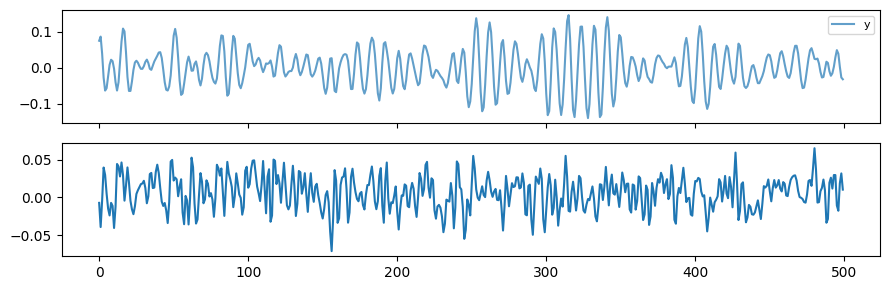

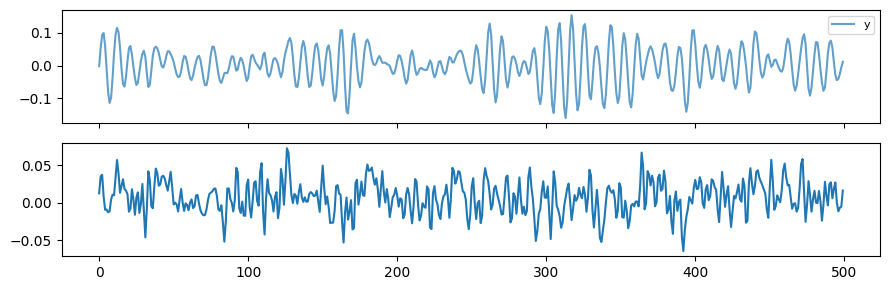

In [2]:
dls = create_dls_silverbox(bs=16, win_sz=500, stp_sz=10)
dls.show_batch(max_n=2)

## Standard Simulation Baseline

Train a standard RNN for comparison. This model sees only the input u(t) and
must predict y(t) without any output feedback. It serves as a baseline to
highlight the difference autoregressive models make.

epoch,train_loss,valid_loss,fun_rmse,time
0,0.005111,0.003652,0.004633,00:03
1,0.002525,0.002773,0.003808,00:02
2,0.002667,0.002071,0.002977,00:02
3,0.002857,0.001814,0.002758,00:02
4,0.002479,0.002225,0.002976,00:02
5,0.002446,0.001814,0.002696,00:02
6,0.002275,0.001607,0.002486,00:02
7,0.002582,0.002550,0.003383,00:02
8,0.001262,0.000996,0.002017,00:02
9,0.000802,0.000802,0.001959,00:02


Standard RNN: [0.0008017512154765427, 0.0019590852316468954]


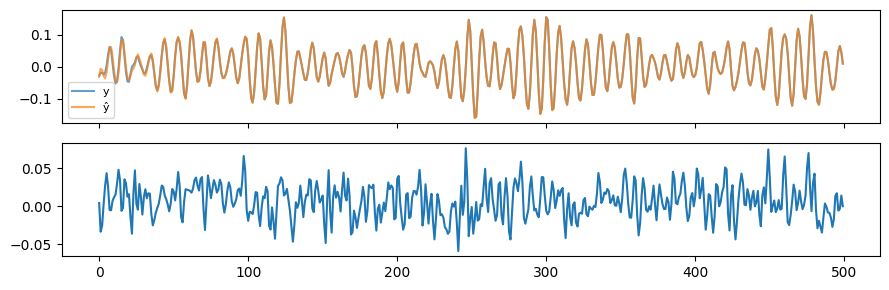

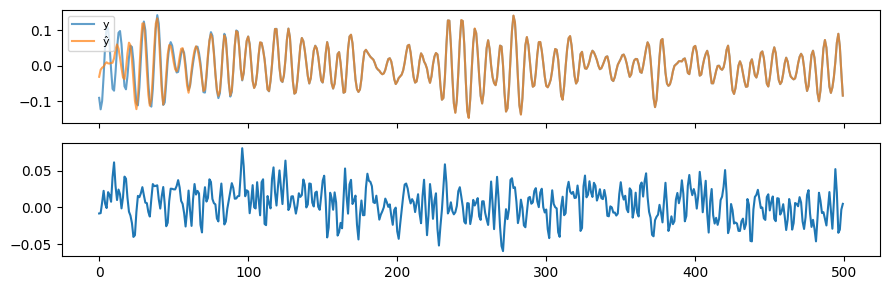

In [3]:
lrn_std = RNNLearner(dls, rnn_type='lstm', hidden_size=40, n_skip=50, metrics=[fun_rmse])
lrn_std.fit_flat_cos(n_epoch=10, lr=3e-3)
lrn_std.show_results(max_n=2)
print(f"Standard RNN: {lrn_std.validate()}")

## Autoregressive RNN

`AR_RNNLearner` wraps the model with autoregressive behavior and adds
`TimeSeriesRegularizer` automatically. `alpha` and `beta` control activation
and temporal regularization respectively -- AR models need these for stability.

Key parameters:

- **`rnn_type='lstm'`**: use LSTM cells for the recurrent layer.
- **`hidden_size=40`**: 40 hidden units in the LSTM.
- **`alpha=1.0`**: penalty weight for large activations (AR regularization).
- **`beta=1.0`**: penalty weight for abrupt activation changes between
  timesteps (TAR regularization).

epoch,train_loss,valid_loss,fun_rmse,time
0,0.000547,0.000364,0.000691,00:02
1,0.000297,0.000224,0.000382,00:02
2,0.000196,0.000143,0.000250,00:02
3,0.000219,0.000158,0.000211,00:02
4,0.000228,0.000257,0.000280,00:02
5,0.000212,0.000250,0.000309,00:02
6,0.000219,0.000207,0.000229,00:02
7,0.000220,0.000100,0.000129,00:03
8,0.000113,0.000114,0.000146,00:02
9,0.000016,0.000013,0.000033,00:03


AR-RNN: [1.3474375009536743e-05, 3.3124724723165855e-05]


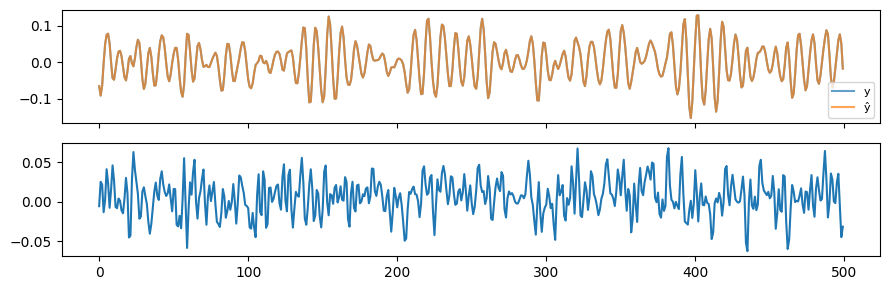

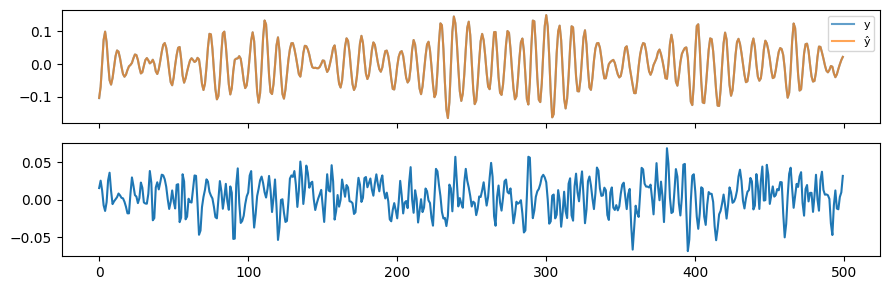

In [4]:
lrn_ar = AR_RNNLearner(
    dls, rnn_type='lstm', hidden_size=40,
    alpha=1.0, beta=1.0, metrics=[fun_rmse]
)
lrn_ar.fit_flat_cos(n_epoch=10, lr=3e-3)
lrn_ar.show_results(max_n=2)
print(f"AR-RNN: {lrn_ar.validate()}")

## Autoregressive TCN

AR mode also works with temporal convolutional networks. `AR_TCNLearner`
combines causal convolutions with autoregressive output feedback. The
`hl_depth` parameter controls the number of TCN blocks (and therefore the
receptive field, which is `2**hl_depth` timesteps).

epoch,train_loss,valid_loss,fun_rmse,time
0,0.027143,0.020344,0.025391,00:04
1,0.002078,0.002706,0.002887,00:04
2,0.001600,0.003239,0.003979,00:03
3,0.001402,0.001825,0.002009,00:03
4,0.001275,0.001253,0.001463,00:03
5,0.001107,0.001965,0.002408,00:03
6,0.001148,0.001597,0.001634,00:03
7,0.001030,0.001169,0.001205,00:03
8,0.000598,0.000324,0.000374,00:03
9,0.000102,0.000094,0.000151,00:03


AR-TCN: [9.363219578517601e-05, 0.00015142557094804943]


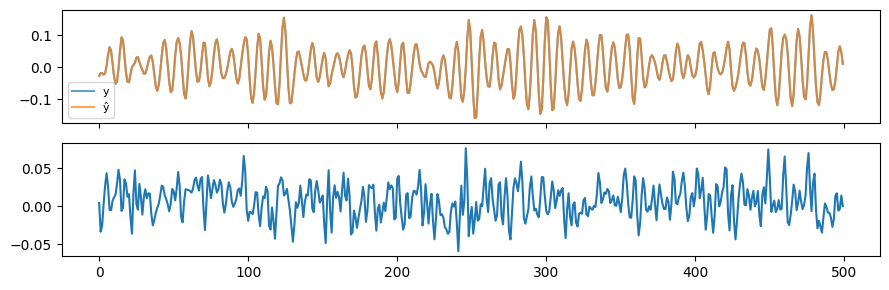

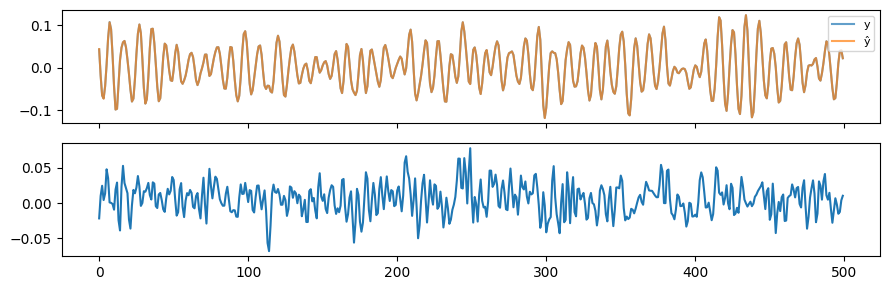

In [5]:
lrn_ar_tcn = AR_TCNLearner(dls, hl_depth=4, metrics=[fun_rmse])
lrn_ar_tcn.fit_flat_cos(n_epoch=10, lr=3e-3)
lrn_ar_tcn.show_results(max_n=2)
print(f"AR-TCN: {lrn_ar_tcn.validate()}")

## Stability and Regularization

AR models can diverge during free-running inference if prediction errors
accumulate. Regularization helps:

- **`alpha`** penalizes large activations, keeping the model in a
  well-behaved region.
- **`beta`** penalizes abrupt changes in predictions, encouraging smoothness.
- Higher `alpha` and `beta` improve stability but may reduce accuracy on
  easy regions.

Train with stronger regularization to demonstrate the trade-off:

epoch,train_loss,valid_loss,fun_rmse,time
0,0.000996,0.000335,0.000761,00:02
1,0.000276,0.000236,0.000318,00:02
2,0.000235,0.000169,0.000218,00:02
3,0.000231,0.000177,0.000227,00:02
4,0.000247,0.000324,0.000352,00:02
5,0.000236,0.000110,0.000153,00:03
6,0.000267,0.000266,0.000332,00:03
7,0.000247,0.000250,0.000318,00:02
8,0.000120,0.000115,0.000136,00:02
9,0.000022,0.000020,0.000039,00:02


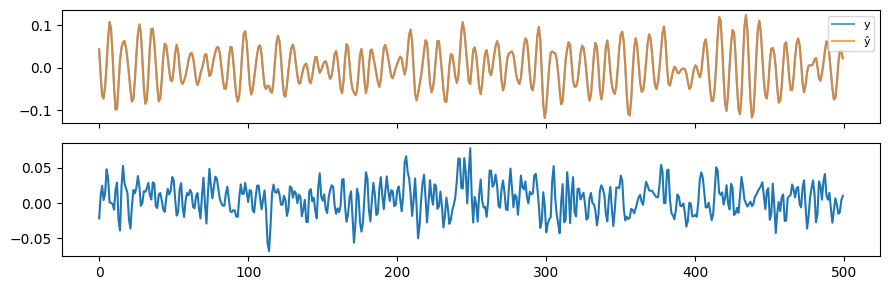

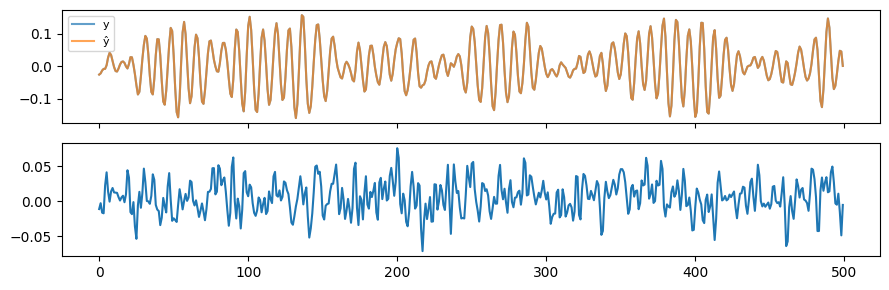

In [6]:
lrn_ar_strong = AR_RNNLearner(
    dls, rnn_type='lstm', hidden_size=40,
    alpha=3.0, beta=3.0, metrics=[fun_rmse]
)
lrn_ar_strong.fit_flat_cos(n_epoch=10, lr=3e-3)
lrn_ar_strong.show_results(max_n=2)

## Key Takeaways

- AR models feed their own predictions back as input for multi-step-ahead
  simulation.
- Teacher forcing during training provides stable gradients; free-running at
  inference tests stability.
- `AR_RNNLearner` and `AR_TCNLearner` handle the autoregressive logic
  automatically.
- Regularization (`alpha`, `beta`) is essential to prevent error accumulation
  and divergence.
- Trade-off: stronger regularization leads to more stable but potentially
  less accurate predictions.